## Setup
Lets import the librarys and set plotting styles:

In [1]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv
import math

import pymc  as pm
#from   pymc3.backends import SQLite
from   scipy  import optimize
from   aesara import tensor as tt

import matplotlib.pyplot as plt
import arviz as az

az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Data
This example of a simple linear regression uses data from two UKESM runs that map changes in Top of Atmopshere outgoing radiation vs global temperature change in response to a instanatinous quadupuling if CO2. The runs are test runs done by Chantelle (thanks Chantelle!) but on something still being developed, so don't read into them too much!

We're not going to use them for what they were designed for (hunting equilibrium in a run in disequilibrium). I might do that in another notebook. Here we're just gonna compare the two slopes and see how different they are. There are frequentist ways to do it, but using Bayesian inference is much cleaner and easier to understand.

Lets import and visulaise the data. And not worry any more about what the data is. There just two sets of x's and y's :)

In [2]:
dat = pd.read_csv('data/TOA_vs_TAS.csv')

x1 = dat['TOA_with'].values
y1 = dat['Temp_with'].values

x2 = dat['TOA_without'].values
y2 = dat['Temp_without'].values

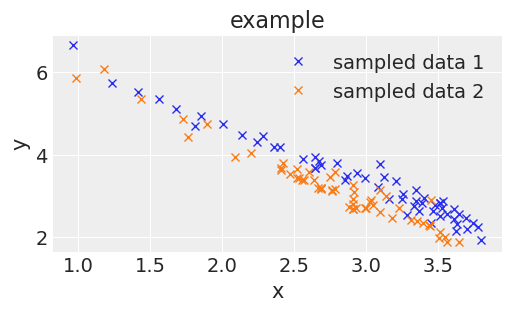

In [3]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="example")
ax.plot(x1, y1, "x", label="sampled data 1")
ax.plot(x2, y2, "x", label="sampled data 2")
plt.legend(loc=0);

## Model description


This is what we're gonna optimise:

\begin{eqnarray}
    f(x, y_0, \beta) &=& y_0 + \beta \times x \\[1em]
\end{eqnarray}


This gives us a nice, simple 3 parameter regression model $\gamma = \{y_0, \beta, \epsilon \}$, where $\epsilon$ is error, that we will compare against $y_i$


## Bayesian model definition
A simple explanation of Baye's law is:

\begin{equation}
    P(\gamma|Y) \propto P(\gamma)\cdot P(Y|\gamma)
\end{equation}

where $Y$ is our data set ${y_i}$, and $\gamma$ our set of unexplained parameters that describe the response of our _proposed understanding_ of this system as it varies with $X$.

### Prior definitions
Because I have no idea what the uncertainty on the hyperparameters should look like, I've made the priors as uninformed as possible. Some of them could have more information or distributions based on updated qualitative knowledge of the bounds, but it's quiet easy to play around with that if you have more information for your own data.

Our priors assume that $y_0$ is most likely to mean  and sdev of $Y$:

\begin{eqnarray}
    P(y_0 = y) &=& \mathcal{N}(y, \bar{Y}, \sigma(Y)) \\[1em]
    \mathcal{N}(x, \mu, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\left(\frac{x - \mu}{\sigma}\right)^2\right\}
\end{eqnarray}

Having said we are going to ignore the what the data is here ;), based on the sources being TOA vs gtlobal temp, we can say that the linear regression WILL have a negative gradient. And the range of ${y_i}$ to ${x_i}$ is a cool estimate of the maximum likely gradient. And exponential distribution, which says a gradent of 0 (a good null hypothois) is most likely, but with a decay parameter that gives our ratio a fighting chance is a pretty good prior:

\begin{eqnarray}
    P(\beta= x) &=& - \mathcal{E}(x, 1/R) \\[1em]
\end{eqnarray}

\begin{eqnarray}
    R &=& \frac{max(Y) - min(Y)}{max(X) - min(X)} \\[1em]
\end{eqnarray}


Finally, we assume the noise outside the model, $\epsilon$ is unbiases and independant of $x$. Noise cannot be less than zero, so we present $\epsilon$ with a generous log-normal distribution:
\begin{eqnarray}
    P(\epsilon= x) &=& \mathcal{N}(log(x), log(0), 21) \\[1em]
\end{eqnarray}



### Posterior sampling
Bayesian inference updates all these proirs in light of observations. To do this, we need to define a $P(X|\gamma)$. Again, we are summing errors or noise is indepandant of our models variables, and therefore the likelihood of $X$ given $\gamma$ is a simple normal distribution:

\begin{eqnarray}
    P(Y| \gamma) &=& \Pi_i^n \mathcal{N}({y_i}, f(x, y_0, \beta), \epsilon) \\[1em]
\end{eqnarray}

Note that this probablity is multtplitive.. This has two implications: 
1. The more observations we use, the less influance the parameters have. With big datasets, priors do little more than set phyisical bounds.
1. pymc actually works on log-probablity $P(X | \gamma)$ can get very small very quickly. We dont have to worry about this nor, but its worth bearing in mind for if we start implementing custom functions.

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to infer the posterior solutions for each of the model parameters. In this case we are using a  No-U-Turn (NUTS) sampling (which is the new kid on the block), which is amazing to read about, but probably not here. 

Back to the code.., `pymc` is quite funky and does a huge amount of things. This is a long version of defining a linear regression model. There are shorter ways for the specifiic task (in another notebook), but writing it out a little longhand now makes developing more advanced Bayesian Models much easier.

In [4]:
def run_regression(xs, ys):
    with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
        # Define priors
        epsilon = pm.LogNormal("epsilon", 0, 10)
        y0 = pm.Normal("y0", np.mean(ys), sigma=np.std(ys))
        beta = pm.Normal("beta", 0, (np.max(ys) - np.min(ys))/(np.max(xs) - np.min(xs)))

        prediction = y0 + beta * xs
        
        # Define likelihood
        likelihood = pm.Normal("mod", mu=prediction, sigma=epsilon, observed=ys)
    
        # Inference!
        # draw 1000 posterior samples using NUTS sampling
        trace = pm.sample(1000, return_inferencedata=True)
        # This next step helps with plotting later. You dont always need it
        pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        
    return(trace)# y_test)

In [5]:
trace1 = run_regression(x1, y1)
trace2 = run_regression(x2, y2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, y0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8828, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, y0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8808, but should be close to 0.8. Try to increase the number of tuning steps.


## looking at the results

### The inference
We can see how the inference did by plotting the trace. The right shows each sampled paramater value in turn, and the left shows the reultsant distribution. Basically,after some initial parameter samples, NUTS settles down to sampling a parameter combination based on the likeihood of that paramater combo. That means that to get an idea of the likihood of our parameters, we just collect all these samples.

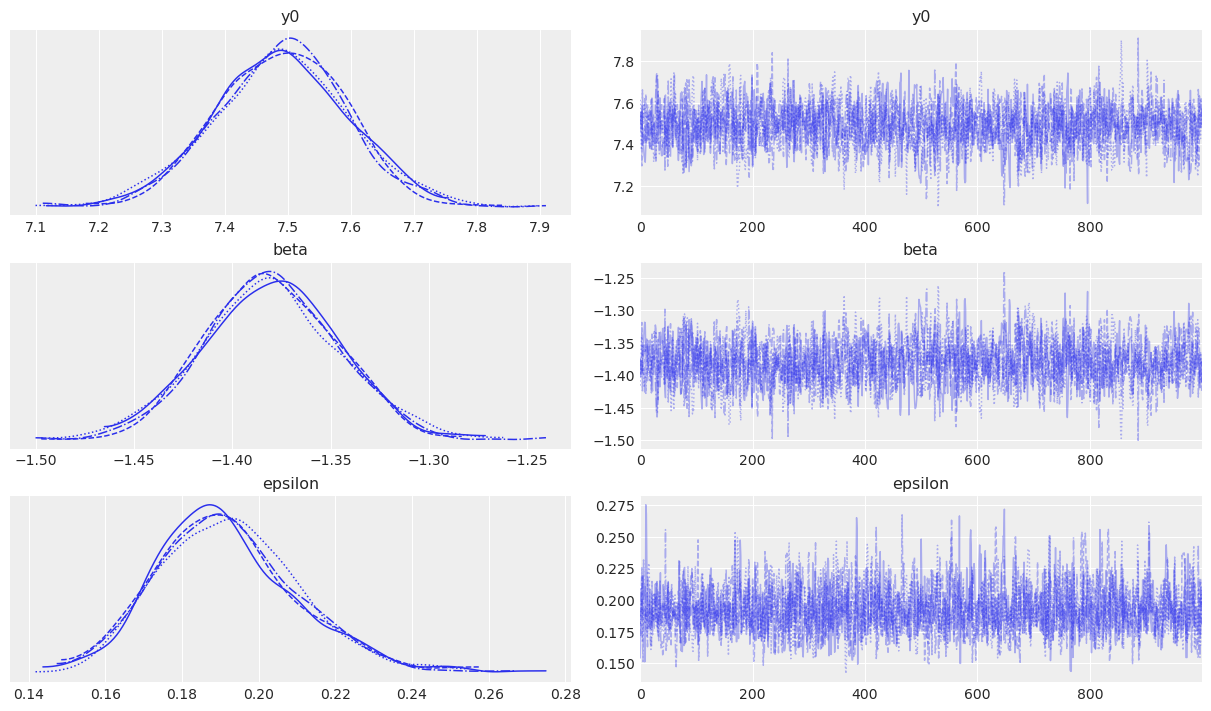

In [6]:
az.plot_trace(trace1, figsize=(12, 7));

Co-variation in parameters can be important, specially in more complicated models than this. Although its hard to visualise co-variation in multi-dimentional paramater space, a paired plot can give some cool insights. There are more adavnce tools for exploring parameter space that we can look at later if we need

array([[<AxesSubplot:ylabel='beta'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='y0', ylabel='epsilon'>,
        <AxesSubplot:xlabel='beta'>]], dtype=object)

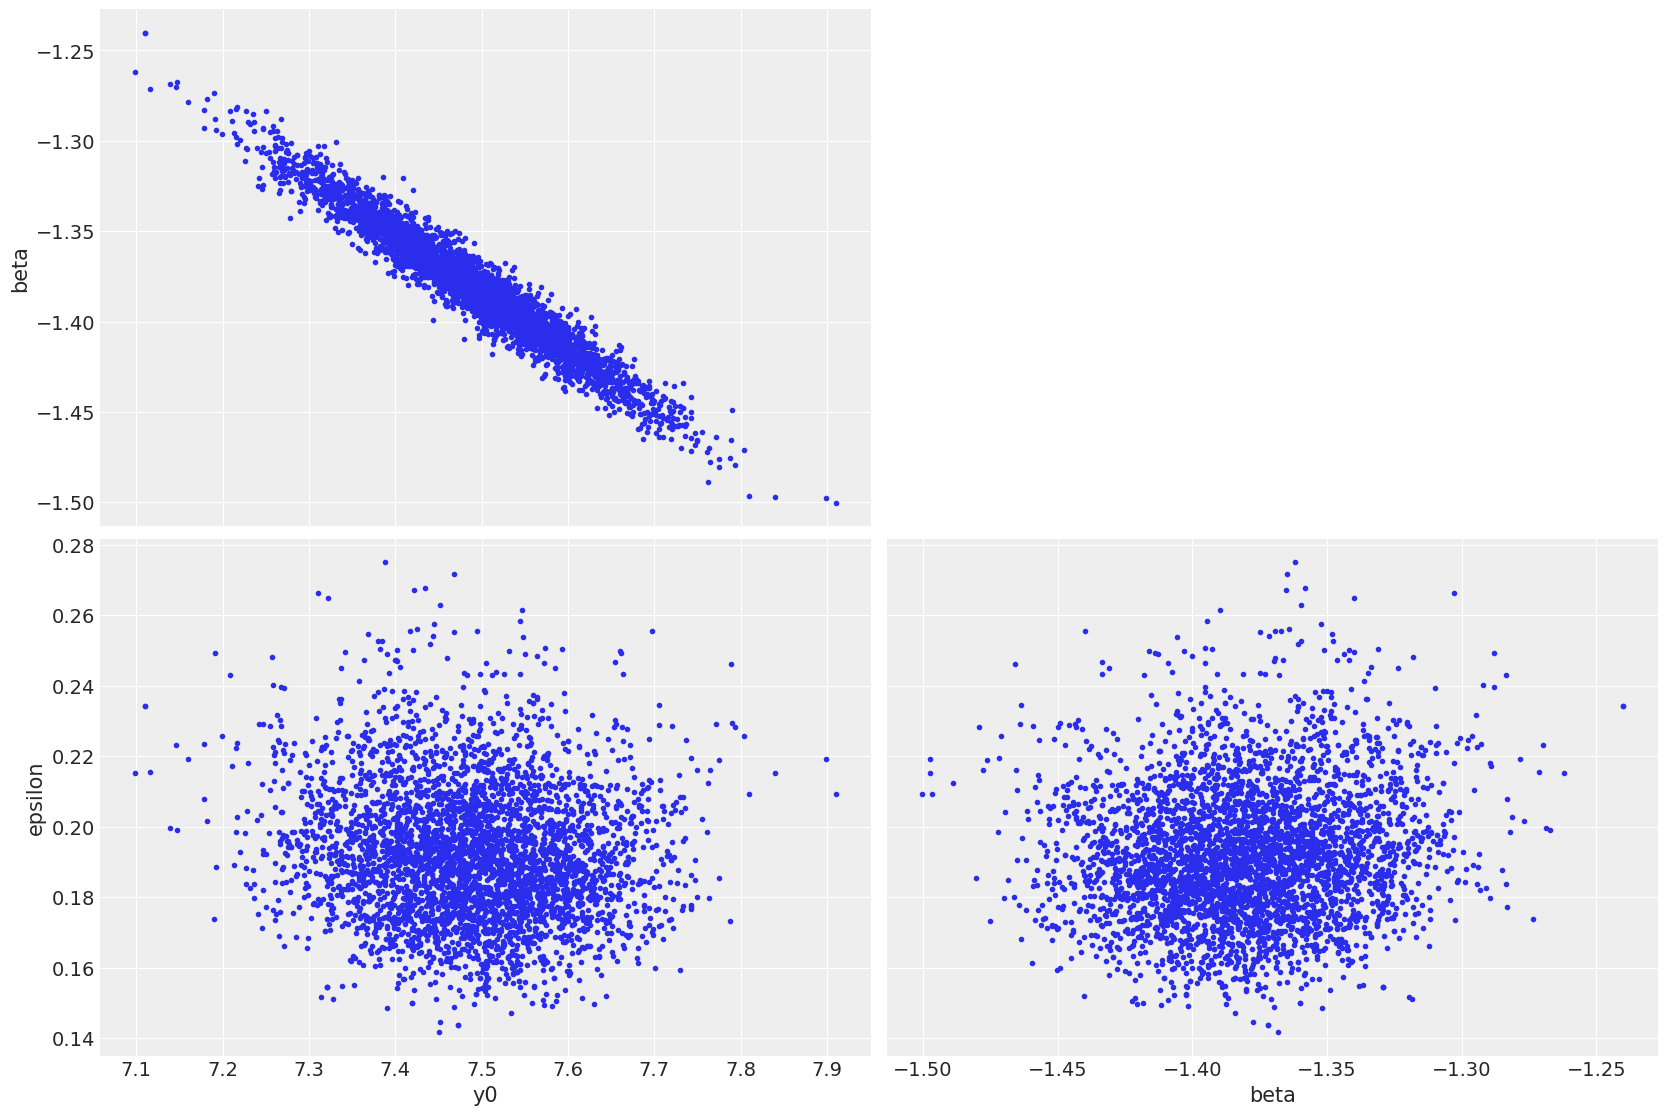

In [7]:
az.plot_pair(trace1)

Cos we have so many parameter samples, we can plot a trend line with an uncertainty range. This looks much like a frequentist confidence or predictive line.

<AxesSubplot:>

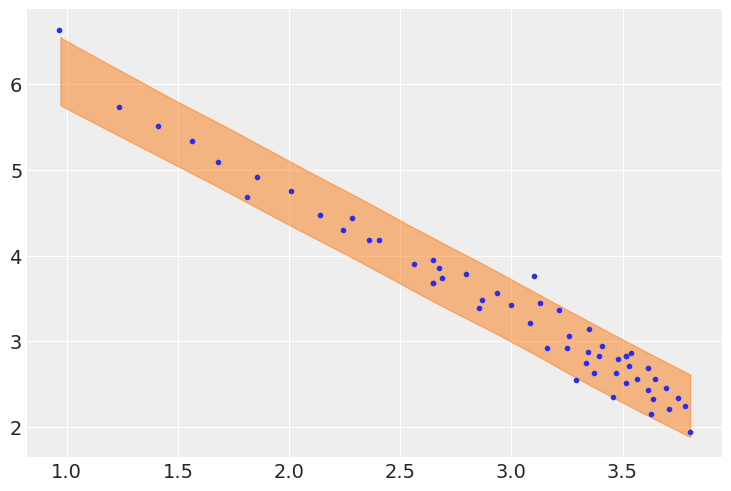

In [8]:
plt.plot(x1, y1, '.')
az.plot_hdi(x1, trace1.posterior_predictive["mod"])


## Comparing gradients
This works with any parameter test, not just our $\beta$. Also, by comparing just one parameter, remember that you are loosing some information about co-variance on parameters: maybe this parameter looks similar between the two runs, but they still fall very far apart in parameter space. Ignoring this info is okay for some application’s (testing ability of models to simulate trends for example), but others, you might want to do something a bit fancier.

You could probably use any of you favourite distribution comparison tests. As our parameter is roughly normally distributed, with limits $[-\infty, \infty]$, a simple area under combined curve works for me. Though the test depends on why you're comparing gradients, so pick what you know and what it most relevant.


In [9]:
beta1 = trace1.posterior["beta"].values 
beta2 = trace2.posterior["beta"].values

min_beta = np.min(np.append(beta1, beta2))
max_beta = np.max(np.append(beta1, beta2))
nbins = int(np.ceil(np.sqrt(beta1.size))) 

bins = np.linspace(min_beta, max_beta, nbins)

dist1 = np.histogram(beta1, bins)[0]
dist2 = np.histogram(beta2, bins)[0]

np.sqrt(np.sum(dist1*dist2))/np.sum(dist1)

0.14758747406199485

You can think of this number a bit like a p-value (it's not quiet, but it's doing the same thing). Its between 0 and 1, and the smaller it is, the more signifcant the difference between the two gradients.